# Model 2: Random Forest

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

### Feature Engineering

In [2]:
df = pd.read_csv(
    "../data/processed/hourly_energy.csv",
    parse_dates=["datetime"],
    index_col="datetime"
).sort_index()

In [3]:
target = "Global_active_power"

df_feat = df.copy()
df_feat["hour"] = df_feat.index.hour
df_feat["dayofweek"] = df_feat.index.dayofweek
df_feat["month"] = df_feat.index.month

df_feat["lag_1"] = df_feat[target].shift(1)
df_feat["lag_24"] = df_feat[target].shift(24)
df_feat["lag_168"] = df_feat[target].shift(168)

df_feat = df_feat.dropna()

feature_cols = ["hour", "dayofweek", "month", "lag_1", "lag_24", "lag_168"]
X = df_feat[feature_cols]
y = df_feat[target]

### Time Split

In [4]:
n = len(df_feat)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

### Metrics

In [5]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred, eps=1e-6):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), eps))) * 100

### Naive Baselines

In [6]:
y_full = df_feat[target]

# Naive (t-1)
naive_pred = y_full.shift(1).loc[y_val.index]
mask = ~naive_pred.isna()
naive_mae = mae(y_val[mask], naive_pred[mask])
naive_rmse = rmse(y_val[mask], naive_pred[mask])
naive_mape = mape(y_val[mask], naive_pred[mask])

# Seasonal naive (t-24)
seasonal_pred = y_full.shift(24).loc[y_val.index]
mask2 = ~seasonal_pred.isna()
seasonal_mae = mae(y_val[mask2], seasonal_pred[mask2])
seasonal_rmse = rmse(y_val[mask2], seasonal_pred[mask2])
seasonal_mape = mape(y_val[mask2], seasonal_pred[mask2])

### Ridge Regression

In [7]:
ridge_model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=1.0, random_state=42))
])

ridge_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None


### Random Forest 

In [8]:
# initial rf
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

In [9]:
# train model 
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

### Predict on Validation

In [10]:
# ridge regression evaluation
y_val_pred = ridge_model.predict(X_val)

ridge_mae = mae(y_val, y_val_pred)
ridge_rmse = rmse(y_val, y_val_pred)
ridge_mape = mape(y_val, y_val_pred)

ridge_mae, ridge_rmse, ridge_mape

(np.float64(0.4211751474842441),
 np.float64(0.5931126153487501),
 np.float64(47.06824096512819))

In [11]:
# random forest evaluation
y_val_pred_rf = rf_model.predict(X_val)

rf_mae = mae(y_val, y_val_pred_rf)
rf_rmse = rmse(y_val, y_val_pred_rf)
rf_mape = mape(y_val, y_val_pred_rf)

rf_mae, rf_rmse, rf_mape

(np.float64(0.3909959859577765),
 np.float64(0.5599442471306062),
 np.float64(43.31562853470196))

### Compare All Models

In [12]:
results = pd.DataFrame({
    "Model": ["Naive (t-1)", "Seasonal Naive (t-24)", "Ridge Regression", "Random Forest"],
    "MAE": [naive_mae, seasonal_mae, ridge_mae, rf_mae],
    "RMSE": [naive_rmse, seasonal_rmse, ridge_rmse, rf_rmse],
    "MAPE (%)": [naive_mape, seasonal_mape, ridge_mape, rf_mape]
}).sort_values("MAE")

results

,Model,MAE,RMSE,MAPE (%)
3,Random Forest,0.390996,0.559944,43.315629
2,Ridge Regression,0.421175,0.593113,47.068241
0,Naive (t-1),0.455819,0.685320,44.038366
1,Seasonal Naive (t-24),0.666785,0.959524,75.522061


### Feature Importance for Random Forest

In [13]:
# extracting importance scores
feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance

lag_1        0.610413
lag_168      0.111579
lag_24       0.102363
hour         0.096451
month        0.042181
dayofweek    0.037013
dtype: float64

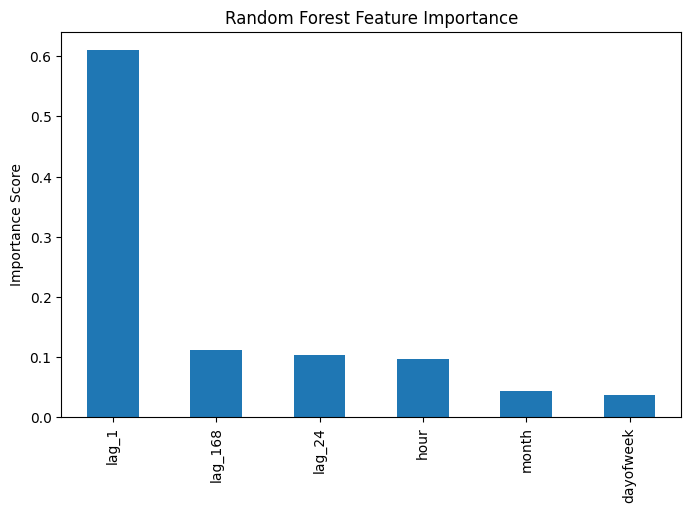

In [15]:
### plot feature importance
plt.figure(figsize=(8,5))
feature_importance.plot(kind="bar")
plt.title("Random Forest Feature Importance")
plt.ylabel("Importance Score")
plt.show()